# Solar power production model

The following notebook is a shortned version of a project to build a model that can predict solar energy production for every hour of the next day. All of the exploratory work is removed, for a cleaner and shorter notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Data
### Importing data

In [3]:
target = pd.read_parquet('data/train_targets.parquet')

In [4]:
X_estimated = pd.read_parquet('data/X_train_estimated.parquet')

In [5]:
X_observed = pd.read_parquet('data/X_train_observed.parquet')

### Plotting some of the data

In [6]:
X_observed


,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-06-02 22:00:00,7.7,1.230,1744.900024,0.0,0.0,1744.900024,0.0,280.299988,0.0,0.0,0.0,0.0,98.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.799988,0.0,0.0,994.200012,1000.299988,0.0,0.0,73.099998,1006.299988,NaN,0.0,0.0,-0.0,0.1,342.834015,-3.202000,0.0,285.899994,100.0,39640.101562,3.7,-3.6,-0.8,-0.0
1,2019-06-02 22:15:00,7.7,1.229,1734.000000,0.0,0.0,1734.000000,0.0,280.299988,0.0,0.0,0.0,0.0,99.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.500000,0.0,0.0,993.900024,999.900024,0.0,0.0,72.199997,1006.000000,NaN,0.0,0.0,-0.0,0.2,346.294006,-3.650000,0.0,286.100006,100.0,40123.898438,3.6,-3.6,-0.6,-0.0
2,2019-06-02 22:30:00,7.7,1.228,1723.500000,0.0,0.0,1723.500000,0.0,280.299988,0.0,0.0,0.0,0.0,99.199997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.099976,0.0,0.0,993.599976,999.599976,0.0,0.0,71.199997,1005.599976,NaN,0.0,0.0,-0.0,0.2,349.768005,-3.998000,0.0,286.299988,100.0,40628.300781,3.6,-3.6,-0.4,-0.0
3,2019-06-02 22:45:00,7.7,1.226,1713.400024,0.0,0.0,1713.400024,0.0,280.299988,0.0,0.0,0.0,0.0,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.799988,0.0,0.0,993.299988,999.299988,0.0,0.0,70.199997,1005.299988,NaN,0.0,0.0,-0.0,0.2,353.251007,-4.247000,0.0,286.600006,100.0,41153.601562,3.5,-3.5,-0.2,-0.0
4,2019-06-02 23:00:00,7.7,1.225,1703.599976,0.0,0.0,1703.599976,0.0,280.299988,0.0,0.0,0.0,0.0,99.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.500000,0.0,0.0,993.000000,999.000000,0.0,0.0,69.199997,1005.000000,NaN,0.0,0.0,-0.0,0.2,356.742004,-4.393000,0.0,286.799988,100.0,41699.898438,3.5,-3.5,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118664,2022-10-21 00:00:00,5.0,1.292,NaN,0.0,0.0,NaN,0.0,273.700012,0.0,0.0,0.0,0.0,2.800000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1018.400024,0.0,0.0,1005.500000,1011.799988,0.0,0.0,82.699997,1018.099976,NaN,0.0,0.0,-0.0,0.0,16.612000,-36.306000,0.0,276.899994,2.8,25791.000000,1.3,-0.4,1.2,-0.0
118665,2022-10-21 00:15:00,5.0,1.292,NaN,0.0,0.0,NaN,0.0,273.700012,0.0,0.0,0.0,0.0,2.300000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1018.299988,0.0,0.0,1005.400024,1011.700012,0.0,0.0,83.099998,1018.000000,NaN,0.0,0.0,-0.0,0.0,21.132999,-35.762001,0.0,276.799988,2.3,28560.599609,1.4,-0.6,1.2,-0.0
118666,2022-10-21 00:30:00,5.0,1.292,NaN,0.0,0.0,NaN,0.0,273.700012,0.0,0.0,0.0,0.0,1.700000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1018.200012,0.0,0.0,1005.299988,1011.599976,0.0,0.0,83.400002,1017.900024,NaN,0.0,0.0,-0.0,0.0,25.594000,-35.095001,0.0,276.600006,1.7,31317.800781,1.4,-0.8,1.2,-0.0
118667,2022-10-21 00:45:00,5.0,1.292,NaN,0.0,0.0,NaN,0.0,273.600006,0.0,0.0,0.0,0.0,1.100000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1018.000000,0.0,0.0,1005.099976,1011.400024,0.0,0.0,83.800003,1017.700012,NaN,0.0,0.0,-0.0,0.0,29.988001,-34.311001,0.0,276.500000,1.1,34062.601562,1.5,-1.0,1.1,-0.0


The observed datasat is containing the acctual weather conitions, while the estimated is containing weather predictions

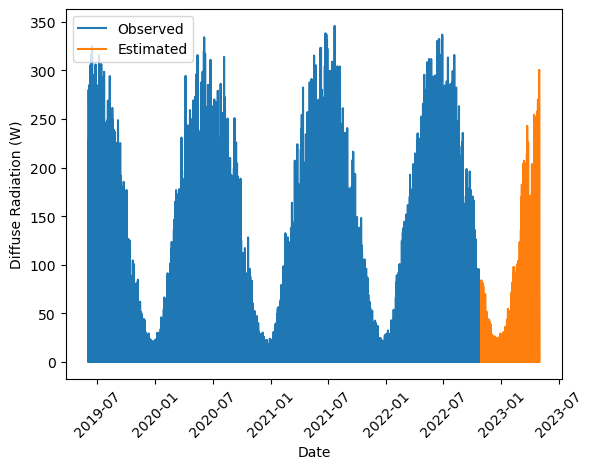

In [7]:
plt.plot(X_observed['date_forecast'], X_observed['diffuse_rad:W'], label='Observed')
plt.plot(X_estimated['date_forecast'], X_estimated['diffuse_rad:W'], label='Estimated')
plt.xlabel('Date')
plt.ylabel('Diffuse Radiation (W)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [8]:
target

,time,pv_measurement
0,2019-06-02 22:00:00,0.00
1,2019-06-02 23:00:00,0.00
2,2019-06-03 00:00:00,0.00
3,2019-06-03 01:00:00,0.00
4,2019-06-03 02:00:00,19.36
...,...,...
34080,2023-04-30 19:00:00,9.02
34081,2023-04-30 20:00:00,0.00
34082,2023-04-30 21:00:00,0.00
34083,2023-04-30 22:00:00,0.00


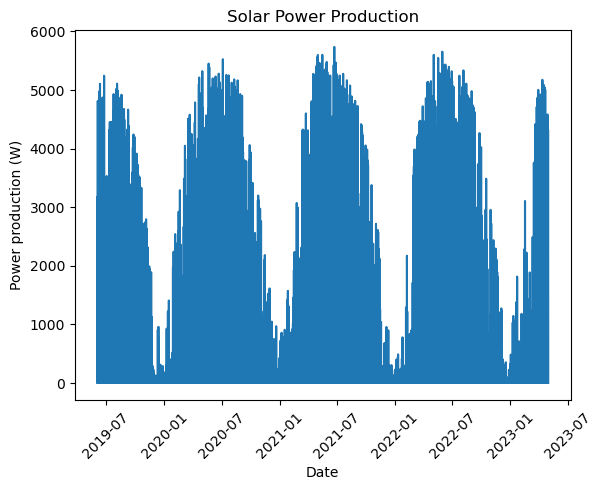

In [9]:
plt.plot(target['time'], target['pv_measurement'])
plt.xlabel('Date')
plt.ylabel('Power production (W)')
plt.title('Solar Power Production')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

Scales ceiling height

In [10]:
scale = X_observed.loc['2020-03-25':, 'ceiling_height_agl:m'].max() / X_observed.loc['2019-07-01':'2020-03-25', 'ceiling_height_agl:m'].max()

X_observed.loc[:'2020-03-25', 'ceiling_height_agl:m'] *= scale

In [11]:
X_estimated.drop(columns=['date_calc'], inplace=True)


In [12]:
def convertDate(df, date_col):
    day_of_year = df[date_col].dt.dayofyear
    normalized_day = (day_of_year - 1) / 365
    df['day_curve'] = np.sin(2 * np.pi * normalized_day)
    hour = df[date_col].dt.hour
    minute = df[date_col].dt.minute

    combined = hour + minute/60

    df['hour_curve'] = np.sin(2*np.pi*combined/24)

    df.set_index(date_col, inplace=True)


In [13]:

# Change the date format and sets date as index
target.set_index('time', inplace=True)

convertDate(X_estimated, 'date_forecast')

convertDate(X_observed, 'date_forecast')

In [14]:
data = [X_estimated, X_observed]

for i in range(len(data)):
    print(type(data[i]))
    drop_col = [col for col in data[i].columns if 'snow' in col]
    drop_col.extend(['elevation:m', 'is_day:idx', 'clear_sky_energy_1h:J','dew_point_2m:K','diffuse_rad_1h:J','direct_rad_1h:J','pressure_100m:hPa','pressure_50m:hPa','sfc_pressure:hPa','t_1000hPa:K','total_cloud_cover:p', 'prob_rime:p', 'precip_type_5min:idx', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx', 'is_in_shadow:idx', 'super_cooled_liquid_water:kgm2'])
    data[i] = data[i].drop(columns=drop_col)

    data[i]['azimuth_cos_T'] = -np.cos(data[i]['sun_azimuth:d']/180*np.pi)
    data[i]['rad_x_cloudCover'] = data[i]['clear_sky_rad:W'] * data[i]['effective_cloud_cover:p']/100

    lead_features_df = data[i].copy()
    new_columns = []
    new_column_names = []

    for feature in data[i].columns.difference(['date_forecast', 'hour_curve', 'day_curve']):
        new_columns.append(data[i][feature].shift(1))
        new_columns.append(data[i][feature].shift(2))
        new_columns.append(data[i][feature].shift(3))
        new_columns.append(data[i][feature].shift(-1))
        new_columns.append(data[i][feature].shift(-2))
        new_columns.append(data[i][feature].shift(-3))

        new_column_names.extend([f'{feature}_{shift}m_lag' for shift in [15, 30, 45]])
        new_column_names.extend([f'{feature}_{shift}m_lead' for shift in [15, 30, 45]])
    
    new_columns = pd.concat(new_columns, axis=1)
    new_columns.columns = new_column_names

    data[i] = pd.concat([data[i], new_columns], axis=1)
    

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [15]:
X_estimated = data[0]
X_observed = data[1]

# Preparing dataset

The power production contains data for every hour, while the weather is predicted every 15 min. Therefore we creates these two datasets, to keep more inforation

In [16]:
combined = pd.concat([X_observed, X_estimated]).join(target, how='inner')
combined = combined.dropna(subset=['pv_measurement'])

In [17]:
combined_15 = pd.concat([X_observed, X_estimated]).join(target, how='outer')
combined_15['pv_measurement'] = combined_15['pv_measurement'].ffill()

After some exploration, we found some nonense data that we decided to remove

In [18]:
start_date = '2022-10-21 00:00:00'
end_date = '2022-10-28 22:00:00'

combined.drop(combined.loc[start_date:end_date].index, inplace=True)
combined_15.drop(combined_15.loc[start_date:end_date].index, inplace=True)

Some of the models, does not like spesial characters in the column names

In [19]:
from sklearn.model_selection import train_test_split
import re
combined = combined.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

combined_15 = combined_15.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### Splitting to X and y

In [20]:
X_data = combined.drop(columns=['pv_measurement'])
y_data = combined['pv_measurement']


X_data_15 = combined_15.drop(columns=['pv_measurement'])

Noramlizes the X values

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_data)
X_data_scaled = scaler.transform(X_data)
X_data_15_scaled = scaler.transform(X_data_15)

X_data = pd.DataFrame(X_data_scaled, columns=X_data.columns, index=X_data.index)

X_data_15 = pd.DataFrame(X_data_15_scaled, columns=X_data_15.columns, index=X_data_15.index)

Creates train and test  data

In [22]:
test_start_date = '2021-07-20 00:00:00'
test_end_date = '2021-07-30 00:00:00'

X_train = pd.concat([X_data.loc[:test_start_date], X_data.loc[test_end_date:]])
y_train = pd.concat([y_data.loc[:test_start_date], y_data.loc[test_end_date:]])

X_test = X_data.loc[test_start_date:test_end_date]
y_test = y_data.loc[test_start_date:test_end_date]

In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")


# Defining Stacking functions

In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

def train_and_predict(models, X, y, X_test, n_splits=5):
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    # Initialize a dictionary to hold the predictions of each model
    model_train_predictions = {}
    model_test_predictions = {}

    # Iterate over each model
    for model_name, model in models.items():
        print(f'Training {model_name}...')
        
        # Initialize a DataFrame to hold the predictions of the current model
        model_train_predictions[model_name] = pd.DataFrame()
        model_test_predictions[model_name] = pd.DataFrame()

        # K-fold Cross Validation model evaluation
        fold_no = 1
        for train, test in kfold.split(X, y):
            # Generate a print
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')

            # Fit data to model
            model.fit(X.iloc[train], y.iloc[train])

            # Generate generalization metrics
            predictions = model.predict(X.iloc[test])
            print(f'Score for fold {fold_no}: {mean_absolute_error(y.iloc[test], predictions)}')

            # Store the predictions of the current fold in a DataFrame
            fold_predictions = pd.DataFrame(model.predict(X))
            model_train_predictions[model_name] = pd.concat([model_train_predictions[model_name], fold_predictions], axis=1)

            # Predict on the test set and store the predictions in a DataFrame
            test_predictions = pd.DataFrame(model.predict(X_test))
            model_test_predictions[model_name] = pd.concat([model_test_predictions[model_name], test_predictions], axis=1)

            fold_no = fold_no + 1

        # Sort the train set predictions and average the test set predictions across all folds
        model_train_predictions[model_name] = model_train_predictions[model_name].mean(axis=1)
        model_test_predictions[model_name] = model_test_predictions[model_name].mean(axis=1)

    return model_train_predictions, model_test_predictions


models = {
    'lgbm_model': lgb.LGBMRegressor(
        n_jobs=4,
        colsample_bytree = 0.9475337647224076, 
        learning_rate = 0.045592564258931566, 
        max_depth = 8, 
        n_estimators = 700, 
        num_leaves = 100, 
        subsample = 0.601967016806479
    ),
    'cat_model': CatBoostRegressor(
        bagging_temperature = 0.7378554663350414,
        border_count = 100, 
        depth = 8, 
        iterations = 1000, 
        l2_leaf_reg = 0.012184856499092163, 
        learning_rate = 0.08771473097605541, 
        random_strength = 0.5010746002603824,
        eval_metric='MAE'
    ),
    'xgb_model' : xgb.XGBRegressor(
        colsample_bylevel = 0.6271084032736475,
        colsample_bytree = 0.6891200569300842,
        gamma = 0.7188221908641431,
        iterations = 1000,
        learning_rate = 0.07066060748279693,
        max_depth = 8,
        min_child_weight = 3,
        n_estimators = 200,
        reg_alpha = 1.0561019503845397,
        reg_lambda = 4.886536933525814,
        subsample = 0.9834397418107923
    )
}

In [25]:
stacking_model = {
    'XGBregressor': xgb.XGBRegressor(
    colsample_bylevel = 0.6625351881046275, 
    colsample_bytree = 0.7090615971304609, 
    gamma = 0.30325853173466527, 
    iterations = 400, 
    learning_rate = 0.04329055231549767, 
    max_depth = 5, 
    min_child_weight = 6, 
    n_estimators = 170, 
    reg_alpha = 0.003769836675097778, 
    reg_lambda = 2.48928058741362, 
    subsample = 0.500100229092168,
    eval_metric='mae'
    )
}

# Remove Outliers

In [26]:
from sklearn.model_selection import KFold
import lightgbm as lgb

def find_outliers(X_data, y_data, model, threshold, n_splits=5):
    # Initialize the KFold object
    kfold = KFold(n_splits=n_splits)
    
    # Separate features and target
    X = X_data
    y = y_data
    
    # Placeholder for outliers
    outliers = []
    
    for train_index, test_index in kfold.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        predictions = model.predict(X_test)
        
        # Find instances where the absolute difference between 
        # the predicted and actual values is greater than the threshold
        diff = np.abs(predictions - y_test)
        outlier_indices = diff[diff > threshold].index.tolist()
        
        # Add these outliers to the list
        outliers.extend(outlier_indices)
    
    # Return a dataframe of just the outliers
    return X_data.loc[outliers]



model = lgb.LGBMRegressor(
        n_jobs=4,
        colsample_bytree = 0.9475337647224076, 
        learning_rate = 0.045592564258931566, 
        max_depth = 8, 
        n_estimators = 700, 
        num_leaves = 100, 
        subsample = 0.601967016806479
    )


In [27]:
threshold = 2500
outliers = find_outliers(X_train, y_train, model, threshold)
print(f"Outliers found in A with threshold of {threshold}: {len(outliers)}")

Outliers found in A with threshold of 2500: 109


In [28]:
X_train.drop(outliers.index, axis=0, inplace=True)
y_train.drop(outliers.index, axis=0, inplace=True)


# Stacking

In [29]:
X_train_stacked, X_test_stacked = train_and_predict(models, X_train, y_train, X_test)

Training lgbm_model...
------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: 169.7645284927648
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: 164.8795998855997
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: 170.8352633946175
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: 161.05143475277143
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: 167.0109394569109
Training cat_model...
------------------------------------------------------------------------
Training for fold 1 ...
0:	learn: 755.1573393	total: 88.2ms	remaining: 1m 28s
1:	learn: 698.2498587	total: 121ms	remaining: 1m
2:	learn: 647.5231876	total: 154ms	remaining: 51.1s
3:	learn: 601.3735043	total: 195ms	re

In [30]:
X_train_stacked = pd.DataFrame(X_train_stacked)
X_test_stacked = pd.DataFrame(X_test_stacked)

## Extending dataset with features

In [31]:
X_train_stacked.index = X_train.index
X_test_stacked.index = X_test.index

X_train_stacked_extended = pd.concat([X_train_stacked, X_train[['rad_x_cloudCover']]], axis=1)
X_test_stacked_extended = pd.concat([X_test_stacked, X_test[['rad_x_cloudCover']]], axis=1)

In [32]:
_, pred_nooutliers_radx = train_and_predict(stacking_model, X_train_stacked_extended, y_train, X_test_stacked_extended, n_splits=5)

Training XGBregressor...
------------------------------------------------------------------------
Training for fold 1 ...
[12:52:33] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "iterations" } are not used.

Score for fold 1: 60.582914951095354
------------------------------------------------------------------------
Training for fold 2 ...
[12:52:35] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "iterations" } are not used.

Score for fold 2: 61.1314841224968
------------------------------------------------------------------------
Training for fold 3 ...
[12:52:36] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "iterations" } are not used.

Score for fold 3: 62.414406403377484
------------------------------------------------------------------------
Training for fold 4 ...
[12:52:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "iterati

In [33]:
pred_nooutliers_radx = pred_nooutliers_radx['XGBregressor']


# Results

In [35]:
pred_nooutliers_radx.index = y_test.index

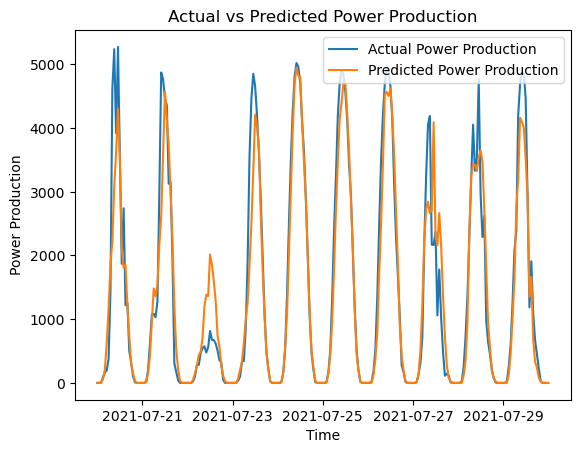

In [36]:
plt.figure()
plt.plot(y_test.index, y_test.values, label='Actual Power Production')
plt.plot(pred_nooutliers_radx.index, pred_nooutliers_radx.values, label='Predicted Power Production')
plt.xlabel('Time')
plt.ylabel('Power Production')
plt.title('Actual vs Predicted Power Production')
plt.legend()

# Display the plot
plt.show()